## Experiment with 2-D DFT

Since we have two-dimensional fringes it makes more sense to use a 2-D Fourier transform. We are not interested in the phase of the tranform but only in the power spectrum a 2-D DFT can increase the SNR since each fringe in the image contributes to the power spectrum. It is also easier to see where the noise comes from in a 2-D DFT.

In [1]:
%matplotlib notebook
import numpy as np
import numpy.ma as ma
from matplotlib import pyplot as plt
#from scipy.signal import find_peaks
import scipy.ndimage
from photutils.detection import find_peaks

from astropy.visualization import hist
from astropy import units as u
from astropy.nddata import CCDData
from astropy.stats import sigma_clipped_stats

from astropy.io import fits

#import ccdproc as ccdp

<IPython.core.display.Javascript object>


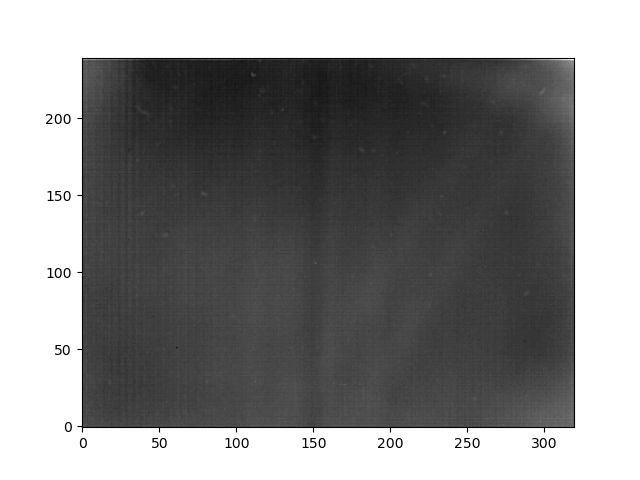

In [2]:
def fitsImage(filename):
    '''
    Utility function to extract data from FITS file.
    Parameters:
    filename (string): Name of FITS file including extension.

    Returns:
    float ndarray: The 2-D array containing the image
    '''
    hdul = fits.open(filename)
    data = hdul[0].data.copy()
    hdul.close()
    return data

# Test it
img = fitsImage('fringe.fts')
fig, ax = plt.subplots()
ax.imshow(img, cmap='gray_r', origin='lower')


Load the fringe data, dark, beam A only, beam B only.

In [3]:
# Where can I get this?
gain = 1.5
exposure_time = 0.1


# Load the .fits files into a NumPy arrays
fringes = fitsImage('fringe.fts')
beamA = fitsImage('beamA.fts')
beamB = fitsImage('beamB.fts')
dark_counts = fitsImage('background.fts')

# Not really useful since I do not know these parameters
dark_current = gain * dark_counts / exposure_time

# Print the array's shape
shape = fringes.shape
print(shape)

(240, 320)


Do histogram to identify hot pixels in the dark. It would be useful to have darks with different integration time to improve the statistics of hot pixels and dark current.

<IPython.core.display.Javascript object>


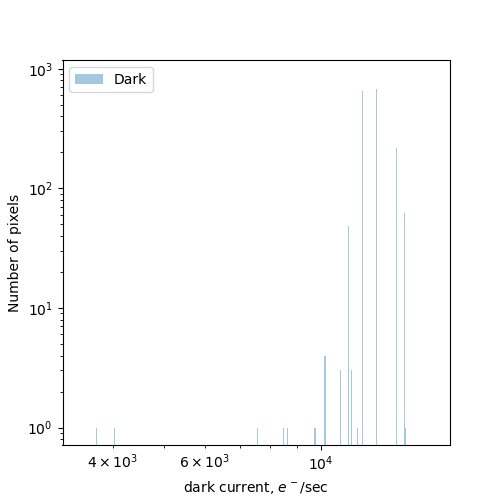

In [4]:
plt.figure(figsize=(5, 5))

hist(dark_counts.flatten(), bins=5000, density=False, label='Dark', alpha=0.4)
#hist(dark_1000.data.flatten(), bins=5000, density=False, label='1000 sec dark', alpha=0.4)
plt.xlabel('dark current, $e^-$/sec')
plt.ylabel('Number of pixels')
plt.loglog()
plt.legend();

Use masked array to mask hot pixels. The masked pixels will not be used in calculations.

In [5]:
hot_pixels = (dark_counts > 15686)
dark_counts_m = ma.masked_array(dark_counts, mask=hot_pixels)
fringes_m = ma.masked_array(fringes, mask=hot_pixels)
beamA_m = ma.masked_array(beamA, mask=hot_pixels)
beamB_m = ma.masked_array(beamB, mask=hot_pixels)
hot_pixels.sum()

321

Reduce fringe data subtracting beam background and dark counts

In [6]:
redFringe = (fringes_m - dark_counts_m) - (beamA_m + beamB_m - 2 * dark_counts_m) / 2 
redFringe.min()

-1465.5

Do I need the dark other than finding hot pixels/dead pixels? The dark cancels out! 

In [7]:
redFringe = fringes_m - beamA_m / 2 - beamB_m / 2 
redFringe = redFringe - redFringe.min()
redFringe.min()

0.0

The white pixels in the image are masked pixels that will be ignored in calculations

<IPython.core.display.Javascript object>


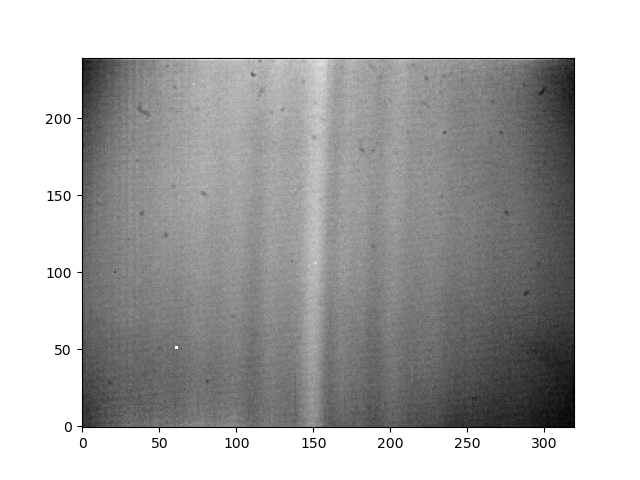

In [8]:
# Create a figure and an axes object
fig, ax = plt.subplots()
ax.imshow(redFringe, cmap='gray', origin='lower')

Calculate 1-D and 2-D power spectra and normalise to '1' for later comparison.

In [9]:
# 1-D power spectrum
ps = np.abs(np.fft.fftshift(np.fft.fft2(redFringe)))
ps = ps / ps.max()

# 2-D power spectrum
ps2 = np.abs(np.fft.fftshift(np.fft.fft(redFringe[shape[0] // 2,:])))
ps2 = ps2 /ps2.max()

Mask the vertical line in the power spectrum and the side lobes.

In [10]:
mask = np.zeros(ps.shape)
mask[:,shape[1]//2] = True
mask[shape[0]//2,155:166] = True
psm = ma.masked_array(ps, mask=mask)

Show thw masked power spectrum. This should avoid detection of peaks that are not part of the power spectrum. It is a bit of a fudge. There must be a better way...

<IPython.core.display.Javascript object>


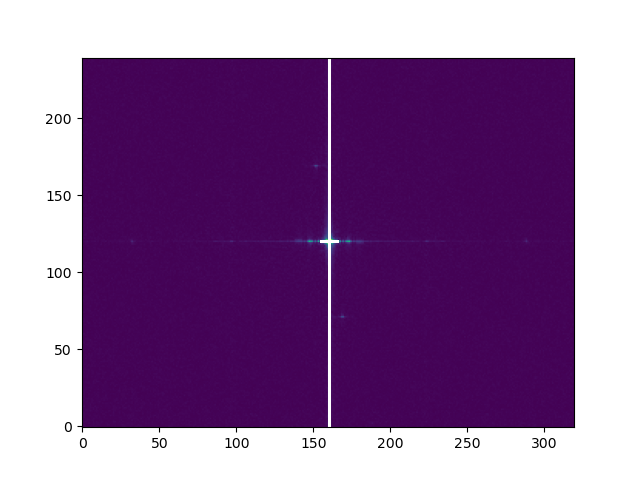

In [11]:
fig, ax = plt.subplots()
ax.imshow(psm, origin='lower')

Now find the lines passing through fringe peaks. If the fringes are not perfectly vertical the line will have the inclination of the fringes af the power spectrum likewise.

In [12]:
# find a threshold for peak detection from the FFT
mean, median, std = sigma_clipped_stats(psm, sigma=3.0)
threshold = median + (5. * std)

# Find peaks in the 2-D power spectrum
peaks = find_peaks(psm, threshold=threshold, npeaks=2).as_array()

# Extract the last two coordinates hoping that they are the complex peaks
x0, y0 = peaks['x_peak'][0], peaks['y_peak'][0] # These are in _pixel_ coordinates!!
x1, y1 = peaks['x_peak'][1], peaks['y_peak'][1]

# Find the gradient and intersect of the line
m = (y1 - y0) / (x1 - x0)
c = y0 - m * x0

# Make the line to extract the pixel values
x = np.arange(ps.shape[1])
y = m*x + c

# Extract the values along the line, using cubic interpolation
zi = scipy.ndimage.map_coordinates(ps, np.vstack((y,x)))

peaks#[-3:-1]

masked_array(data=[(147, 120, 0.013215824550862043),
                   (173, 120, 0.013215824550862041)],
             mask=[(False, False, False), (False, False, False)],
       fill_value=(999999, 999999, 1.e+20),
            dtype=[('x_peak', '<i8'), ('y_peak', '<i8'), ('peak_value', '<f8')])

Show the log() of the 2-D power spectrum to better show the noise. Check thet the line passes through the Fourier peaks otherwise the power spectrum is not extracted. An 'x' marks the position of the detected peaks.

<IPython.core.display.Javascript object>


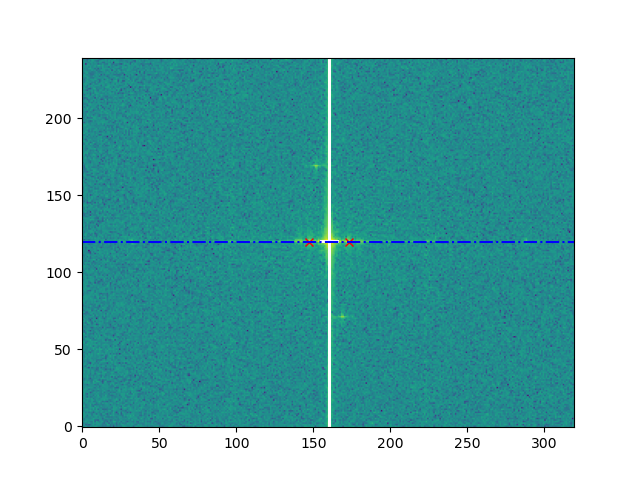

In [13]:
fig, ax = plt.subplots()
ax.imshow(np.log10(psm), origin='lower')
ax.plot(peaks['x_peak'], peaks['y_peak'], 'xr')

ax.plot(x,y, 'b-.')

Show the extracted power spctrum from the line and compare to the power spectrum of the single line extracted from the fringes. High SNR data does not show much difference. It would be interesting to try with low SNR.

<IPython.core.display.Javascript object>


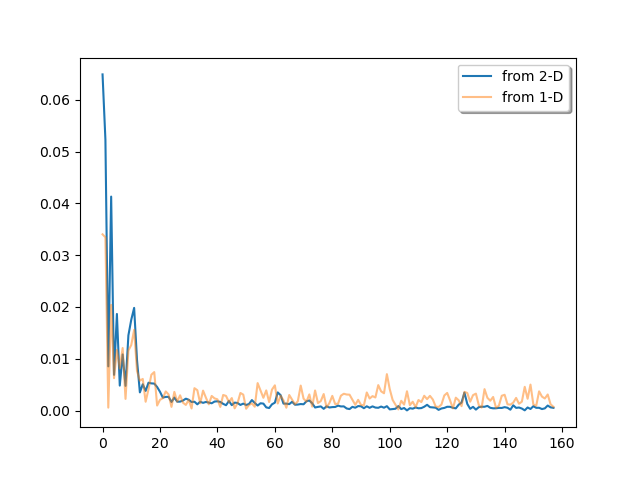

In [14]:
fig, ax = plt.subplots()
l1, = ax.plot(zi[shape[1]//2+2:]*1.5)
l2, = ax.plot(ps2[shape[1]//2+2:], alpha=0.5)
ax.legend((l1, l2), ('from 2-D', 'from 1-D'), loc='upper right', shadow=True)